In [1]:
import sys
import numpy as np
import pandas as pd
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, PandasTools, QED, Descriptors, rdMolDescriptors, Draw

import qeppi as ppi
from rdkit.Chem.QED import qed

%matplotlib inline
pd.options.mode.chained_assignment = None
print(rdBase.rdkitVersion)

2020.09.1


In [2]:
#load qeppi model
q = ppi.QED_Calculator()
q.load("model/QEPPI_CIBCB2021.model")
print("QEPPI_CIBCB2021.model LOADING...")

QEPPI_CIBCB2021.model LOADING...


455


,IDNUMBER,NAME,ADD_INFO,H_ACCEPTORS,H_DONORS,ROTATABLE_BONDS,LOGP,LOGS,TPSA,PRICE,ID,ROMol,SALTDATA,STEREOCHEM
0,AA-504/07224027,"17-(1,5-dimethylhexyl)-10,13-dimethyl-2,3,4,7,...",http://www.specs.net/enter.php?specsid=AA-504/...,1,1,5,8.7399998,-8.9700003,20.23,N05,AA-504/07224027,,NaN,NaN
1,AA-504/07226009,Beta-Sitosterol,http://www.specs.net/enter.php?specsid=AA-504/...,1,1,6,9.6499996,-9.9499998,20.23,N07,AA-504/07226009,,NaN,NaN
2,AA-504/07617049,"4,7-bis(dimethylamino)-3,10,12,12a-tetrahydrox...",http://www.specs.net/enter.php?specsid=AA-504/...,9,5,3,-0.079999998,-3.78,164.63,N05,AA-504/07617049,,NaN,NaN
3,AA-504/20833001,Angelicin (Isopsoralen),http://www.specs.net/enter.php?specsid=AA-504/...,1,0,0,2.0799999,-2.3399999,39.439999,N07,AA-504/20833001,,NaN,NaN
4,AA-504/20833002,Psoralen (Ficusin),http://www.specs.net/enter.php?specsid=AA-504/...,1,0,0,1.67,-1.99,39.439999,N07,AA-504/20833002,,NaN,NaN

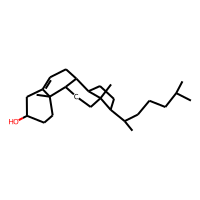
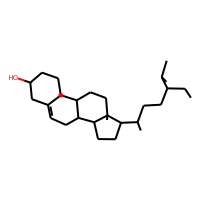
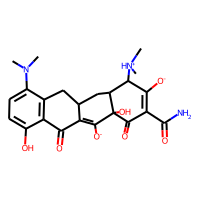
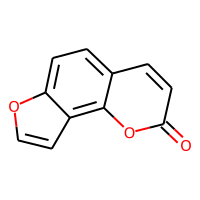
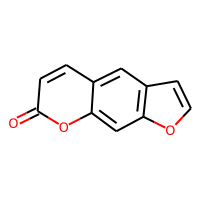

In [3]:
df = PandasTools.LoadSDF('./data/cmpounds.sdf')
print(len(df))
df.head()

,IDNUMBER,ROMol
0,AA-504/07224027,
1,AA-504/07226009,
2,AA-504/07617049,
3,AA-504/20833001,
4,AA-504/20833002,

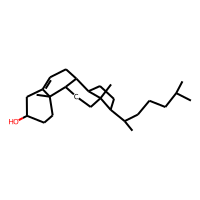
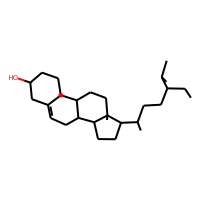
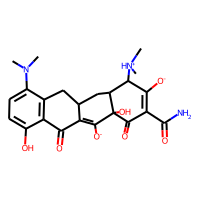
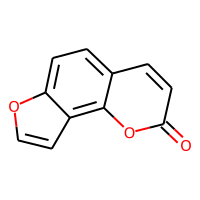
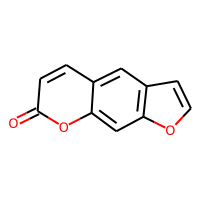

In [4]:
data = df[['IDNUMBER', 'ROMol']]
data.head()

In [5]:
#Lipinski: Rule of five
def rule_of_five(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)
    psa = Descriptors.TPSA(m)
    if (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10):
        return 1
    else:
        return 0

In [6]:
#Rule of Four
def rule_of_four(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)
    rings = AllChem.CalcNumRings(m)
    if (mw >= 400 and logp >= 4 and rings >= 4 and hba >= 4):
        return 1
    else:
        return 0

In [7]:
#Rule of three
def rule_of_three(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)
    rotatable_bonds = Descriptors.NumRotatableBonds(m)
    if (mw <= 300 and logp <= 3 and hbd <= 3 and hba <= 3 and rotatable_bonds <= 3):
        return 1
    else:
        return 0

In [8]:
#Ghose Filter
def ghose_filter(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    NumAtoms= Chem.rdchem.Mol.GetNumAtoms(m)
    mol_refractivity = Chem.Crippen.MolMR(m)
    if (mw >= 160 and mw <= 480 and logp >= 0.4 and logp <= 5.6 and NumAtoms >= 20 and NumAtoms <= 70 and mol_refractivity >= 40 and mol_refractivity <= 130):
        return 1
    else:
        return 0

In [9]:
# Veber Filter
def veber_filter(m):
    rotatable_bonds = Descriptors.NumRotatableBonds(m)
    psa = Descriptors.TPSA(m)
    if (rotatable_bonds <= 10 and psa <= 140):
        return 1
    else:
        return 0

In [10]:
# REOS Filter
def reos_filter(m):
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)
    rotatable_bonds = Descriptors.NumRotatableBonds(m)
    formal_charge = Chem.rdmolops.GetFormalCharge(m)
    NumHeavyAtom = Chem.rdchem.Mol.GetNumHeavyAtoms(m)
    rings = AllChem.CalcNumRings(m)
    if (mw >= 200 and mw <= 500 and logp >= int(0 - 5) and logp <= 5 and hbd >= 0 and hbd <= 5 and hba >= 0 and hba <= 10 and 
        formal_charge >= int(0-2) and formal_charge <= 2 and rotatable_bonds >= 0 and rotatable_bonds <= 8 and NumHeavyAtom >= 15 and NumHeavyAtom <= 50):
        return 1
    else:
        return 0         

,IDNUMBER,ROMol,Ro3,Ro4,Lipinski,Ghose Filter,Veber Filter,REOS Filter,QED,QEPPI
0,AA-504/07224027,,0,0,0,0,1,0,0.488312,0.149903
1,AA-504/07226009,,0,0,0,0,1,0,0.436096,0.151972
2,AA-504/07617049,,0,0,1,0,0,1,0.337567,0.215317
3,AA-504/20833001,,1,0,1,0,1,0,0.506483,0.361118
4,AA-504/20833002,,1,0,1,0,1,0,0.506483,0.361118

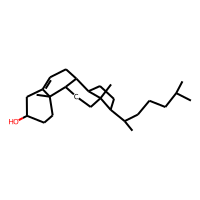
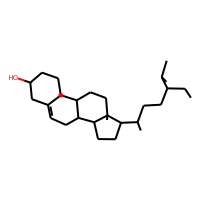
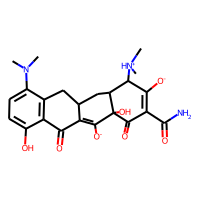
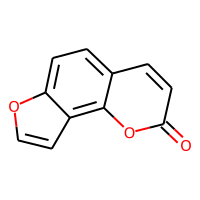
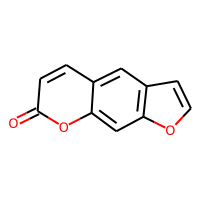

In [11]:
data['Ro3'] = data.ROMol.map(rule_of_three)
data['Ro4'] = data.ROMol.map(rule_of_four)
data['Lipinski'] = data.ROMol.map(rule_of_five)
data['Ghose Filter'] = data.ROMol.map(ghose_filter)
data["Veber Filter"] = data.ROMol.map(veber_filter)
data["REOS Filter"] = data.ROMol.map(reos_filter)
data['QED'] = data.ROMol.map(QED.qed)
data['QEPPI'] = data.ROMol.map(q.qeppi)

data.head()

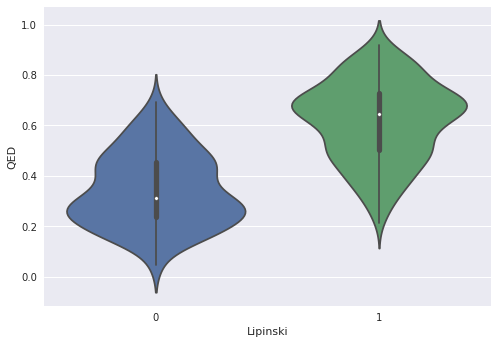

In [12]:
import matplotlib as mpl
import seaborn as sns
with mpl.style.context('seaborn'):
    sns.violinplot(x='Lipinski', y='QED', data=data)

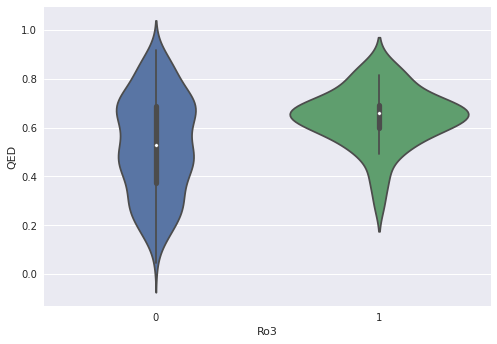

In [13]:
import matplotlib as mpl
import seaborn as sns
with mpl.style.context('seaborn'):
    sns.violinplot(x='Ro3', y='QED', data=data)

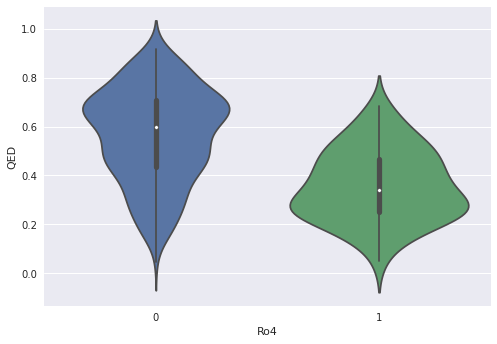

In [14]:
import matplotlib as mpl
import seaborn as sns
with mpl.style.context('seaborn'):
    sns.violinplot(x='Ro4', y='QED', data=data)

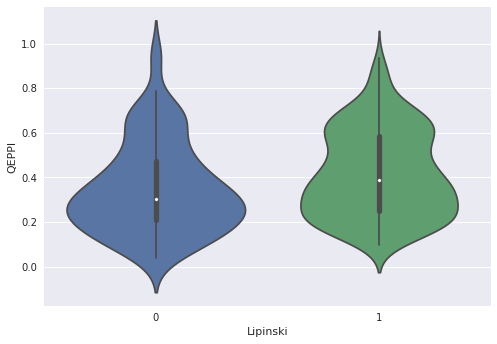

In [15]:
import matplotlib as mpl
import seaborn as sns
with mpl.style.context('seaborn'):
    sns.violinplot(x='Lipinski', y='QEPPI', data=data)

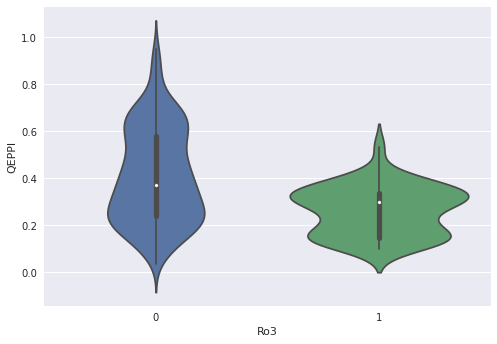

In [16]:
import matplotlib as mpl
import seaborn as sns
with mpl.style.context('seaborn'):
    sns.violinplot(x='Ro3', y='QEPPI', data=data)

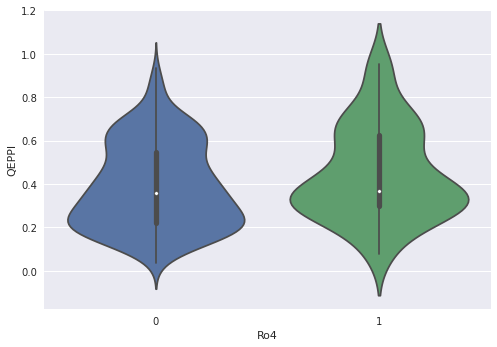

In [17]:
import matplotlib as mpl
import seaborn as sns
with mpl.style.context('seaborn'):
    sns.violinplot(x='Ro4', y='QEPPI', data=data)